In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import *
import glob
import scipy 
from datetime import datetime as dt
import sklearn
sns.style = 'darkgrid'

In [2]:
def convert_stress(level):
    """
    converts input stress level from the scale above into a more usable scale with 1 being feeling great 
    and 5 being stressed out.
    """
    # little stress = 3/5 stressed
    if level == 1: 
        return 3
    # definitely stressed = 4/5
    if level == 2:
        return 4
    # stressed out = 5/5
    if level == 3:
        return 5
    # feeling good = 2/5
    if level == 4: 
        return 2
    # feeling great = 1/5 
    if level == 5:
        return 1
    else:
        return 0

In [4]:
def location_variance(gps_df):
    """
    returns the location variance of the gps dataframe, which is log(variance of latitiude squared plus variance of 
    longitude squared)
    """
    num =  gps_df['lon'].var() + gps_df['lat'].var()
    return log(num)

In [218]:
def process_stress_ema_remove_null(uid, ema_name, desired_column): 
    """
    input: uid for which we want to process the stress EMA
    """
    ema = pd.read_json('dataset/EMA/response/{}/{}_{}.json'.format(ema_name, ema_name, uid))
    
    try: 
        ema[desired_column] = ema[desired_column].where(np.isfinite, ema.null)
    except: 
        pass

        
    ema[desired_column] = pd.to_numeric(ema[desired_column], errors='coerce')
    
    ema = ema[['resp_time', desired_column]]
    ema = ema.dropna()
    
    if ema_name == 'stress': 
        ema['level'] = ema['level'].apply(convert_stress)
    
    return ema

In [219]:
def num_changes(wifi_locations): 
    changes = -1
    previous = None
    
    for location in wifi_locations['location'].values: 
        if location != previous:
            changes += 1
            previous = location
        else: 
            continue
            
    return changes

In [220]:
def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end

In [8]:
def load_activity(uid): 
    # load activity data
    activity = pd.read_csv('dataset/sensing/activity/activity_' + uid + '.csv')
    activity['time'] = pd.to_datetime(activity['timestamp'], unit = 's') 
    activity['day'] = activity['time'].dt.dayofyear
    activity = activity[activity[' activity inference'] != 3]
    return activity

def load_conversation(uid): 
    # load conversation data
    conversation = pd.read_csv('dataset/sensing/conversation/conversation_' + uid + '.csv')
    conversation['convo duration'] = conversation[' end_timestamp'] - conversation['start_timestamp']
    conversation['day'] = pd.to_datetime(conversation['start_timestamp'], unit = 's').dt.dayofyear
    return conversation

def load_darkness(uid): 
    # load darkness data
    darkness = pd.read_csv('dataset/sensing/dark/dark_' + uid + '.csv')
    darkness['day'] = pd.to_datetime(darkness['start'], unit = 's').dt.dayofyear
    darkness['duration'] = darkness['end'] - darkness['start']
    return darkness

def load_bluetooth(uid):
    # load bluetooth data
    bluetooth = pd.read_csv('dataset/sensing/bluetooth/bt_' + uid + '.csv')
    bluetooth['time'] = pd.to_datetime(bluetooth['time'], unit = 's')
    bluetooth['day'] = bluetooth['time'].dt.dayofyear
    return bluetooth

def load_gps(uid):
    # gps data 
    gps = pd.read_csv('dataset/sensing/gps/gps_' + uid + '.csv')
    # data is out of order, this will reformat it. 
    gps.reset_index(inplace = True)
    gps.columns = ('timestamp', 'provider', 'network_type', 'accuracy', 'lat',
                   'lon', 'altitude', 'bearing' ,'speed', 'travelstate', 'null')
    gps = gps.drop("null", 1)
    gps['time'] = pd.to_datetime(gps['timestamp'], unit = 's')
    gps['day'] = gps['time'].dt.dayofyear
    return gps

def load_wifi_locations(uid): 
    # wifi locations data
    wifi_locations = pd.read_csv('dataset/sensing/wifi_location/wifi_location_' + uid + '.csv')
    wifi_locations.reset_index(inplace = True)
    wifi_locations.columns = ("timestamp", "location", "null")
    wifi_locations = wifi_locations.drop("null", 1)
    wifi_locations['time'] = pd.to_datetime(wifi_locations['timestamp'], unit = 's')
    wifi_locations['day'] = wifi_locations['time'].dt.dayofyear
    return wifi_locations

In [13]:
def conversation_in_range(time_interval, convo_df, start_name, end_name): 
    """
    inputs: 
        time_interval -- formatted as (start time, end time, start day, end day)
        convo_df -- a dataframe containing start and end timestamps for a duration measurement 
            (so this function can be used for darkness as well as conversation)
        start_name -- name of the column indicating the start timestamp
        end_name -- name of the column indicating the end timestamp. 
    outputs: 
        the total conversation duration in the time interval.
        
    Note -- I initially named this function for activity so the variable names reflect that, but it can be applied to
    multiple sensor data. 
    
    This function is is similar to the activity in range but applies to dataframes contianing durations so the approach is
    slightly different.  
    """
    # again, unpack interval. 
    start = time_interval[0]
    end = time_interval[1]
    start_day = time_interval[2]
    end_day = time_interval[3]
    
    # look at relevant days 
    if start_day == end_day: 
        conv = convo_df[convo_df['day'] == start_day]
    else: 
        conv = convo_df[convo_df['day'] == start_day].append(convo_df[convo_df['day'] == end_day])
    
    # turn the conversations into intervals. If none exist, the duration is 0. 
    try:
        conv['interval'] = list(zip(pd.to_datetime(conv[start_name], unit = 's'), 
                                    pd.to_datetime(conv[end_name], unit = 's')))
    except:
        return 0

    
    # this function returns the duration of conversation inside the desired interval for each time interval. 
    conv['desired duration'] = conv['interval'].apply(lambda x: conv_range(start, end, x))
    conv = conv.dropna()
    
    # return the sum of all desired intervals. 
    return conv['desired duration'].sum()

In [309]:
def conv_range(start, end, conv_interval): 
    """
    returns the amount of seconds of conversation are in the interval (start, end)
    """
    conv_start = conv_interval[0]
    conv_end = conv_interval[1]
    
    if conv_end < start: 
        return np.nan
    
    elif conv_start > end:
        return np.nan
    
    elif conv_start >= start and conv_end >= end:
        return end - conv_start 
    
    elif conv_start <= start and conv_end <= end:
        return conv_end - start
    
    elif conv_start >= start and conv_end <= end:
        return conv_end - conv_start
    
    elif conv_start <= start and conv_end >= end:
        return end - start
    
def convert_timedeltas(x): 
    """
    converts timedeltas to seconds, leaves any numbers
    """
    try:
        return x.seconds
    except:
        return x 

In [15]:
def activity_in_range(time_interval, activity_df, func = 'act'): 
    """
    inputs: 
        time_interval -- formatted as (start time, end time, start day, end day)
        activity_df -- dataframe for a single user. 
    outputs: 
        the mean activity inference in the time interval.
        
    Note: the activity dataframe and variable names imply 
    """
    
    # unpack the values from the time interval
    start = time_interval[0]
    end = time_interval[1]
    start_day = time_interval[2]
    end_day = time_interval[3]
    
    # only look at relevant days to say runtime
    if start_day == end_day: 
        activity = activity_df[activity_df['day'] == start_day]
    else: 
        activity = activity_df[activity_df['day'] == start_day].append(activity_df[activity_df['day'] == end_day])
        
    # this try except loop takes care of the case where the activity data is an empty dataframe, so we return Nan 
    try: 
        ### these cases are different for different func inputs so this function can be extensible. 
        
        # in this case, we are looking at activity and taking the mean
        if func == 'act':
            return activity[activity['time'].apply(lambda x: time_in_range(start, end, x))][' activity inference'].sum()
        elif func == 'all_act': 
            print(activity[activity['time'].apply(lambda x: time_in_range(start, end, x))][' activity inference'].values)
            return activity[activity['time'].apply(lambda x: time_in_range(start, end, x))][' activity inference'].values
        # in this case, we are looking at bluetooth and take the count
        elif func == 'count':
            return activity[activity['time'].apply(lambda x: time_in_range(start, end, x))].shape[0]
        # in this case we apply the location variance function 
        elif func == 'location variance': 
            return location_variance(activity[activity['time'].apply(lambda x: time_in_range(start, end, x))])
        elif func == 'location changes': 
            return num_changes(activity[activity['time'].apply(lambda x: time_in_range(start, end, x))])
    except:
        # if we find none in count, we return 0. If not, there is no data/average from there so return Nan. 
        if func == 'count': 
            return 0
        return np.nan

In [313]:
#This function returns a new dataframe with all of the activity durations for a particular student throughout the term.
#Only activities longer than 1 minute were considered.
#At the end, we dediced to use total activity duration (sum of activity durations per day) for our model

def activity_analysis(uid):
    activity = pd.read_csv('dataset/sensing/activity/activity_' + uid + '.csv')
    activity = activity[activity[' activity inference'] !=3]
    activity = activity.reset_index()
    #Change the path as needed when running the files on your computer.
    activity['day'] = pd.to_datetime(activity['timestamp'], unit = 's').dt.dayofyear
    daily_activity = activity.groupby('day').mean()
    def shift_counter_activity(data):
        shift_num = 0
        list_shift_num = []
        list_time = []
        list_day = []
        for i in range(0, len(data)):
            if data[' activity inference'][i] != 0:
                try: 
                    if data[' activity inference'][i+1] != 0 and (data.index[i]+1) == data.index[i+1]:
                        shift_num += 1
                    else:
                        list_shift_num.append(shift_num)
                        shift_num = 0
                except:
                    list_shift_num.append(shift_num)
                    shift_num = 0
        return list_shift_num
    activity_shifts = shift_counter_activity(activity)
    edited_act = activity[activity[' activity inference'] !=0]
    edited_act = edited_act.reset_index()
    def shifts_only(list1):
        shifts_only_list = []
        for i in list1:
            if i != 0:
                shifts_only_list.append(i)
        return shifts_only_list
    new_activity_shifts = shifts_only(activity_shifts)
    def get_sums(list1):
        list_sums_b = []
        for i in range(0,len(list1)+1):
            new_list = list1[:i]
            sums = sum(new_list)
            list_sums_b.append(sums)
        return list_sums_b
    list_sums_before_activity = get_sums(activity_shifts)
    def activity_dur(list_shift_num, data):
        time_deltas = []
        day = []
        start_time = []
        for i in range(0, len(list_shift_num)):
            if i == 0:
                time_deltas.append(data['timestamp'][list_shift_num[i]] - data['timestamp'][0])
                day.append(data.day[list_shift_num[i]+i+list_sums_before_activity[i]])
                start_time.append(data.timestamp[list_shift_num[i]+i+list_sums_before_activity[i]])
            elif i != 0:
                time_deltas.append(data['timestamp'][list_shift_num[i]+i+list_sums_before_activity[i]] - data['timestamp'][list_sums_before_activity[i]+i])
                day.append(data.day[list_shift_num[i]+i+list_sums_before_activity[i]])
                start_time.append(data.timestamp[list_shift_num[i]+i+list_sums_before_activity[i]])
        dataframe = pd.DataFrame({'Time Delta': time_deltas, 'day': day, 'Start Time': start_time})
        return dataframe
    activity_dur_df = activity_dur(activity_shifts, edited_act)
    activity_dur_df['end_time'] = activity_dur_df['Start Time'] + activity_dur_df['Time Delta']
    activity_dur_df['start_day'] = pd.to_datetime(activity_dur_df['Start Time'], unit='s').dt.dayofyear
    activity_dur_df['end_day'] = pd.to_datetime(activity_dur_df['end_time'], unit='s').dt.dayofyear
    activity_dur_df = activity_dur_df.rename(columns={'Start Time': 'start_time'})
    #activity_dur_df = activity_dur_df[activity_dur_df['Time Delta'] >= 60]
    activity_dur_day = activity_dur_df.groupby('day')['Time Delta'].sum()
    return activity_dur_df

In [335]:
def deadlines_processing():
    data = pd.read_csv('dataset/education/deadlines.csv')
    data = data.dropna(axis=1, how='all')
    data = data.T
    old_names = list(data.columns)
    new_names = data.iloc[0]
    data.rename(columns=dict(zip(old_names, new_names)), inplace=True)
    data = data.drop(['uid'])
    data['doy'] = pd.to_datetime(data.index)
    data['doy'] = data['doy'].dt.dayofyear
    return data

In [336]:
deadlines_processing()

,u01,u02,u03,u04,u05,u07,u08,u09,u10,u12,...,u49,u50,u51,u52,u53,u54,u57,u58,u59,doy
3/27/2013,0,0,0,0,0,0,0,0,0,1,...,2,0,0,0,0,0,0,0,0,86
3/28/2013,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,87
3/29/2013,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,1,0,0,1,88
3/30/2013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,89
3/31/2013,0,0,0,0,1,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6/1/2013,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,152
6/2/2013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,153
6/3/2013,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,154
6/4/2013,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,155


In [337]:
from sklearn.preprocessing import OneHotEncoder
def ema_intervals_data(uid, window, ema_name, desired_column): 
    """
    inputs: uid -- user id 
            window -- the frame of time (in hours) of how long the interval of sensor collection around each EMA should be. 
    
    Finds desired sensor data within that window of time before and after the EMA. 
    
    Returns: a dataframe containing stress level and desired feature information for each stress response. If the
    dataframe has less than 50 elements returns none (we assume there isn't enough data with less than 50 elements). 
    """
    data = process_stress_ema_remove_null(uid, ema_name, desired_column)
    
    # define the window of time we want to look at for each stress answer. 
    data['start_time'] = data['resp_time'] - pd.to_timedelta(window, unit = 'h')
    data['end_time'] = data['resp_time'] + pd.to_timedelta(window, unit = 'h')
    
    # this will reduce runtime by only looking at sensor data from that day then applying our interval function to it. 
    data['start_day'] = data['start_time'].dt.dayofyear
    data['end_day'] = data['end_time'].dt.dayofyear
    data['doy'] = data['resp_time'].dt.dayofyear
    
    data['dow'] = data['resp_time'].dt.dayofweek
    data = data.join(pd.get_dummies(data['dow']))
    data = data.rename(columns={0: 'Monday', 
                                1: 'Tuesday', 
                                2: 'Wednesday', 
                                3: 'Thursday', 
                                4: 'Friday',
                                5: 'Saturday',
                                6: 'Sunday'})
    
    
    # the time interval is just a tuple of (start time, end time)
    # in the future, we will apply functions to the interval using other dataframes to return desired columns inside
    # the interval
    data['interval'] = tuple(zip(data['start_time'], data['end_time'], data['start_day'], data['end_day']))
    
    # load activity data
    activity = activity_analysis(uid)
    data['activity dur'] = data['interval'].apply(lambda x: conversation_in_range(x, activity, 
                                                                           'start_time', 'end_time'))
    data['activity dur'] = data['activity dur'].apply(convert_timedeltas)
    
    # this will return the total conversation duration for each interval
    conversation = load_conversation(uid)
    data['conversation dur'] = data['interval'].apply(lambda x: conversation_in_range(x, conversation, 
                                                                           'start_timestamp', ' end_timestamp'))
    data['conversation dur'] = data['conversation dur'].apply(convert_timedeltas)
    
    # find the total darkness duration for each interval
    darkness = load_darkness(uid)
    data['darkness dur'] = data['interval'].apply(lambda x: conversation_in_range(x, darkness, 'start', 'end'))
    data['darkness dur'] = data['darkness dur'].apply(convert_timedeltas)
    
    
    # find the number of bluetooth colocations in each interval
    bluetooth = load_bluetooth(uid)
    data['bluetooth colocations'] = data['interval'].apply(lambda x: activity_in_range(x, bluetooth, 'count'))
    
    
    # find the location variance in each stress interval. 
    gps = load_gps(uid)
    data['location variance'] = data['interval'].apply(lambda x: activity_in_range(x, gps, 'location variance'))
    
    # wifi locations
    wifi_locations = load_wifi_locations(uid)
    data['location changes'] = data['interval'].apply(lambda x: activity_in_range(x, wifi_locations, 'location changes'))
    
    #load deadlines data.
    deadlines = deadlines_processing()
    #deadlines = deadlines[deadlines['doy' == data.start_day]]
    deadlines = deadlines[[uid, 'doy']]
    data = pd.merge(data, deadlines, on='doy', how='inner')
    data = data.rename(columns={uid: 'deadlines'})
    
    # drop Nan values
    data = data.dropna()
    
    # only use these features if we have over 50 datapoints
    if data.shape[0] < 20: 
        return None
    
    # return relevant columns. 
    return data #[['resp_time', desired_column, 'location changes', 'activity dur',
                # 'conversation dur', 'darkness dur', 'bluetooth colocations', 'location variance', 'deadlines']]

In [338]:
ema_intervals_data('u01', 5, 'PAM', 'picture_idx')

C:\Users\Lowell\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Lowell\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,resp_time,picture_idx,start_time,end_time,start_day,end_day,doy,dow,Monday,Tuesday,...,Saturday,Sunday,interval,activity dur,conversation dur,darkness dur,bluetooth colocations,location variance,location changes,deadlines
0,2013-03-30 00:31:29,8,2013-03-29 19:31:29,2013-03-30 05:31:29,88,89,89,5,0,0,...,1,0,"(2013-03-29 19:31:29, 2013-03-30 05:31:29, 88,...",3328.0,18427.0,13876.0,34,-13.304166,69.0,0
1,2013-03-30 19:31:10,14,2013-03-30 14:31:10,2013-03-31 00:31:10,89,90,89,5,0,0,...,1,0,"(2013-03-30 14:31:10, 2013-03-31 00:31:10, 89,...",2521.0,19979.0,24149.0,28,-10.669974,93.0,0
2,2013-03-30 22:27:20,16,2013-03-30 17:27:20,2013-03-31 03:27:20,89,90,89,5,0,0,...,1,0,"(2013-03-30 17:27:20, 2013-03-31 03:27:20, 89,...",1489.0,17974.0,23758.0,39,-10.704030,59.0,0
3,2013-03-30 03:52:58,3,2013-03-29 22:52:58,2013-03-30 08:52:58,88,89,89,5,0,0,...,1,0,"(2013-03-29 22:52:58, 2013-03-30 08:52:58, 88,...",2365.0,12335.0,21487.0,33,-17.900377,51.0,0
4,2013-03-30 06:00:05,7,2013-03-30 01:00:05,2013-03-30 11:00:05,89,89,89,5,0,0,...,1,0,"(2013-03-30 01:00:05, 2013-03-30 11:00:05, 89,...",951.0,5892.0,29114.0,32,-17.623536,31.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2013-05-09 02:17:55,6,2013-05-08 21:17:55,2013-05-09 07:17:55,128,129,129,3,0,0,...,0,0,"(2013-05-08 21:17:55, 2013-05-09 07:17:55, 128...",1041.0,28845.0,20848.0,30,-13.306511,28.0,0
128,2013-05-09 23:44:46,14,2013-05-09 18:44:46,2013-05-10 04:44:46,129,130,129,3,0,0,...,0,0,"(2013-05-09 18:44:46, 2013-05-10 04:44:46, 129...",5030.0,12198.0,3593.0,65,-12.038247,61.0,0
129,2013-05-16 08:40:56,15,2013-05-16 03:40:56,2013-05-16 13:40:56,136,136,136,3,0,0,...,0,0,"(2013-05-16 03:40:56, 2013-05-16 13:40:56, 136...",11.0,20768.0,36000.0,6,-19.330717,25.0,0
130,2013-05-13 20:48:34,9,2013-05-13 15:48:34,2013-05-14 01:48:34,133,134,133,0,1,0,...,0,0,"(2013-05-13 15:48:34, 2013-05-14 01:48:34, 133...",5093.0,18972.0,35069.0,27,-12.130753,55.0,1


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, TimeSeriesSplit

def random_forest_importance(features, target, features_names, plot, cv): 
    """
    input: features: features of the machine learning model
           target: labels for the machine learning model
           features_names: the name of each feature column 
           plot: boolean, if True, plot the important features
           cv: boolean, if True, return average cross validation score instead of feature importances. 
    given input features and targets (labels), a random forest model is created to find the importance of each feature to 
    the target. Plots these outcomes. 
    """
    # just from some guess and check, it seems that using 500 estimators greatly reduces the random element of the 
    # classifier
    model = RandomForestClassifier(n_estimators = 500)
    model.fit(features, target)
    
    if plot is True: 
        # to determine if the model is better than random chance(i.e. our important features are actually important),
        # we can check with a cross validation score.
        #print('average cross validation score: {:.2f}'.format(cross_val_score(RandomForestClassifier(n_estimators = 500),
        #                                                                      features, target, cv = 3).mean()))
        n_features = features.shape[1]
        plot_feature_importance(n_features, features_names, model.feature_importances_)
        
    if cv is True: 
        
        tscv = TimeSeriesSplit(n_splits = 5)
        avg_score = 0
        
        for train_index, test_index in tscv.split(features): 
            #print(train_index)
            #print(test_index)
            X_train, X_test = features[train_index], features[test_index]
            y_train, y_test = target[train_index], target[test_index]
            
            forest = RandomForestClassifier(n_estimators = 500)
            forest.fit(X_train, y_train)
            score = forest.score(X_test, y_test)
            #print(train_index, test_index, score)
            avg_score += score/5
            #print(avg_score)
            
        return avg_score
    
    return model.feature_importances_

In [21]:
def plot_feature_importance(n_features, features_names, feature_importance): 
    """
    input: n_features: number of features
           features_names: names of features
           feature_importance: the importance of each feature
    makes a bar plot showing the importance of each feature. 
    """
    plt.barh(range(n_features), feature_importance, align='center')
    plt.yticks(np.arange(n_features), features_names)
    plt.xlabel('feature importance')

In [268]:
def find_cv_scores(uid, window, ema, desired_column, data = None): 
    """
    inputs: uid -- user id
            window -- timeframe to examine
            plot -- if true, plots results
            cv -- if true, returns cross validation scores from stress prediction. 
            
    Finds the intervals of stress around the ema response within the window, predicts stress with those sensor data. 
    returns the feature importance of that stress prediction along with the feature names. 
    """
    
    # load intervals
    if data is None: 
        data = ema_intervals_data(uid, window, ema, desired_column)
    
    feature_names = ['activity inf', 'conversation dur', 'darkness dur',
                                 'bluetooth colocations', 'location variance', 'location changes']
    
    features = data[feature_names].values
    
    target = data[desired_column].values
    
    #feat_import = perm_importance(features, target, feature_names, plot) 
    feat_import = random_forest_importance(features, target, feature_names, plot=False, cv=True)
    
    return feat_import, feature_names    

In [269]:
def find_window_cvs(uid, windows, ema, desired_column, data, plot=False): 
    """
    input: uid -- user id
           windows -- list of windows to look at 
           plot -- boolean that, if true, plots results
    
    This function loops through all the windows and finds cross validation scores for stress prediction using the 
    window of time sensors. 
    
    Returns a row of a dataframe corresponding to the maximimum cross validation value and its window of time. 
    """
    
    df = pd.DataFrame()
    # loop through all the windows
    for window in windows: 
        # this function returns the cross validation of the uid's stress EMA for the given window i
        need = data[data['window'] == window]
        cv = find_cv_scores(uid, window, ema, desired_column, need)[0]
        # add the window and cv score to a dataframe
        df = df.append(pd.DataFrame({'window': window, 'cross validation score': cv}, index = [0]))
    
    # this will make a scatter of the dataframe
    if plot is True: 
        sns.relplot(x='window', y = 'cross validation score', data = df)
    
    # return the row 
    return df

In [278]:
def optimize_windows(windows, ema, desired_column, data): 
    """
    input: windows -- list of windows to look at. 
    
    Loops through all user ids and finds the best (highest cv score) window out of the windows list 
    
    returns a dataframe with each uid and its optimal window with cross validation score. 
    """   
    
    df = pd.DataFrame()
    
    ema_files = glob.glob('dataset/EMA/response/' + ema + '/' + ema + '_*.json')
    uid_start = len('dataset/EMA/response/' + ema + '/' + ema + '_')
    # loops through all the files and averages the feature importance lists
    for file in ema_files: 
        # the uid indexed from the file text
        uid = file[uid_start:uid_start+3]
        # if there aren't enough datapoints, the max_window function will throw an error, so I used a try except loop.
        need = data[data['uid'] == uid]
        x = find_window_cvs(uid, windows, ema, desired_column, need)
        x['uid'] = uid
        max_window = x[x['cross validation score'] == x['cross validation score'].max()]
        df = df.append(max_window, ignore_index = True)
        break
    
    return df

In [287]:
def search_best_windows(best_windows, feature_names, data, desired_column): 
    """
    inputs: 
        best_windows: dataframe containing uid and the best window for each uids
        feature_names: the names of each feature. 
    outputs: 
        new best parameters and cross validation scores in a dataframe created from random parameter searching the random 
        forest models. 
    """    
    results = pd.DataFrame()  
    for uid in best_windows['uid'].unique(): 
        values = best_windows[best_windows['uid'] == uid].iloc[0]
        window = values['window']
        
        need = data[data['uid'] == uid]
        need = need[need['window'] == window]
        features = need[feature_names].values
        target = need[desired_column].values
        
        best_params, best_score = forest_gridsearch(features, target)
        best_params['score'] = [best_score]
        best_params['uid'] = [uid]
        best_params['window'] = [window]
        results = results.append(pd.DataFrame(best_params), ignore_index=True)
    
    return results

In [280]:
from sklearn.model_selection import RandomizedSearchCV
def forest_gridsearch(features, target): 
    """
    adapted from 
    https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    performs a random parameter search on the random forest model and returns the best parameters and best score. 
    """
    # Number of trees in random forest
    n_estimators = [x*100 for x in range(1, 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [x*10 for x in range(1, 10)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                                   cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(features, target)
    
    return rf_random.best_params_, rf_random.best_score_

In [281]:
def aggregate_data(windows, ema, desired_column):
    df = pd.DataFrame()
    
    ema_files = glob.glob('dataset/EMA/response/' + ema + '/' + ema + '_*.json')
    uid_start = len('dataset/EMA/response/' + ema + '/' + ema + '_')
    # loops through all the files and averages the feature importance lists
    for file in ema_files: 
        uid = file[uid_start:uid_start+3]
        for window in windows: 
            data = ema_intervals_data(uid, window, ema, desired_column)
            data['uid'] = uid
            data['window'] = window
            df = df.append(data)
        break

    return df 

In [288]:
def find_best_funcs(windows, ema, desired_column, feature_names): 
    
    data = aggregate_data(windows, ema, desired_column)
    best_windows = optimize_windows(windows, ema, desired_column, data)
    best_funcs = search_best_windows(best_windows, feature_names, data, desired_column)
    
    return best_funcs, data

In [289]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def perm_importance(features, target, n_estimators, min_samples_split, min_samples_leaf, max_features, 
                   max_depth, bootstrap): 
    """
    input: features: features of the machine learning model
           target: labels for the machine learning model
           features_names: the name of each feature column 
           plot: boolean, if True, plot the important features
    
    uses permutation importance with a time series split to return the average feature importance for each split along with 
    the standard deviation of that feature importance
    """
    
    tscv = TimeSeriesSplit(n_splits = 5)
    
    avg_importance = zeros(6)
    avg_std = zeros(6)
    
    for train_index, test_index in tscv.split(features): 
            
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = target[train_index], target[test_index]
    
        model = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf, max_features=max_features,
                                      max_depth=max_depth, bootstrap=bootstrap)
        model.fit(X_train, y_train)
        
        #print('prediction: {}'.format(model.predict(X_test)))
        #print('acutal: {}'.format(y_test))
        
        r = permutation_importance(model, X_test, y_test, n_repeats = 30, random_state = 0)
        
        avg_importance = avg_importance + r.importances_mean/5
        avg_std = avg_std + r.importances_std/5
            
        print(r.importances_mean)
        print(r.importances_std)
    
    return avg_importance, avg_std

In [290]:
def find_all_feature_importance(windows, ema, desired_column): 
    feature_names = ['activity inf', 'conversation dur', 'darkness dur',
                                 'bluetooth colocations', 'location variance', 'location changes']
    best_functions, data = find_best_funcs(windows, ema, desired_column, feature_names)

    corr = data.corr()
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        #cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    
    return data.corr()

    feat_imp_df = pd.DataFrame()
    for i in best_functions.index:
        row = best_functions.iloc[i]
        n_estimators = row['n_estimators']
        min_samples_split = row['min_samples_split']
        min_samples_leaf = row['min_samples_leaf']
        max_features = row['max_features']
        max_depth = row['max_depth']
        bootstrap = row['bootstrap']
        viewing = data[data['uid'] == row['uid']]
        viewing = viewing[viewing['window'] == row['window']]
        features = viewing[feature_names].values
        target = viewing[desired_column].values
        feat_importance = perm_importance(features, target, n_estimators, min_samples_split, min_samples_leaf, max_features, 
                   max_depth, bootstrap)
        feat_imp_df = feat_imp_df.append(pd.DataFrame({'uid': row['uid'], 'importance': feat_importance[0], 
                                                      'std': feat_importance[1], 'sensor': feature_names}))
        
    return feat_imp_df

C:\Users\Lowell\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Lowell\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\Lowell\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.2min finished


,level,location changes,activity inf,conversation dur,darkness dur,bluetooth colocations,location variance,window
level,1.000000,-0.084643,0.071039,-0.067844,0.046366,-0.046329,0.042269,NaN
location changes,-0.084643,1.000000,0.350441,0.711224,-0.155273,0.678604,0.118770,NaN
activity inf,0.071039,0.350441,1.000000,0.404280,0.197900,0.262979,0.263375,NaN
conversation dur,-0.067844,0.711224,0.404280,1.000000,0.028872,0.590706,0.132935,NaN
darkness dur,0.046366,-0.155273,0.197900,0.028872,1.000000,-0.207263,0.125832,NaN
bluetooth colocations,-0.046329,0.678604,0.262979,0.590706,-0.207263,1.000000,0.028648,NaN
location variance,0.042269,0.118770,0.263375,0.132935,0.125832,0.028648,1.000000,NaN
window,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


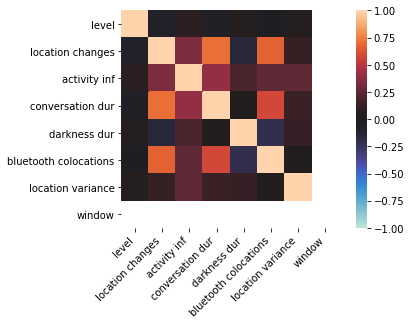

In [291]:
find_all_feature_importance([5], 'stress', 'level')

C:\Users\Lowell\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Lowell\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\Lowell\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished


,picture_idx,location changes,activity inf,conversation dur,darkness dur,bluetooth colocations,location variance,window
picture_idx,1.000000,0.113045,0.023948,0.050843,0.068907,0.111917,-0.031179,NaN
location changes,0.113045,1.000000,0.377778,0.593797,-0.136460,0.660786,0.044935,NaN
activity inf,0.023948,0.377778,1.000000,0.433983,-0.108220,0.260091,0.187328,NaN
conversation dur,0.050843,0.593797,0.433983,1.000000,-0.123992,0.549006,0.115203,NaN
darkness dur,0.068907,-0.136460,-0.108220,-0.123992,1.000000,-0.141970,-0.073783,NaN
bluetooth colocations,0.111917,0.660786,0.260091,0.549006,-0.141970,1.000000,0.005115,NaN
location variance,-0.031179,0.044935,0.187328,0.115203,-0.073783,0.005115,1.000000,NaN
window,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


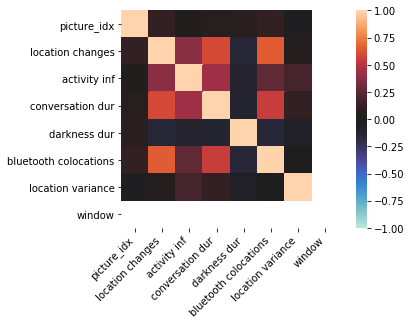

In [292]:
find_all_feature_importance([5], 'PAM', 'picture_idx')

C:\Users\Lowell\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Lowell\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished


,rate,location changes,activity inf,conversation dur,darkness dur,bluetooth colocations,location variance,window
rate,1.000000,0.231180,0.103657,-0.044550,-0.039074,0.254107,0.030558,NaN
location changes,0.231180,1.000000,0.427580,0.443016,0.163196,0.540128,-0.195510,NaN
activity inf,0.103657,0.427580,1.000000,0.332987,-0.010046,0.104168,0.308697,NaN
conversation dur,-0.044550,0.443016,0.332987,1.000000,0.120159,0.393522,0.026227,NaN
darkness dur,-0.039074,0.163196,-0.010046,0.120159,1.000000,-0.033905,-0.211433,NaN
bluetooth colocations,0.254107,0.540128,0.104168,0.393522,-0.033905,1.000000,-0.154179,NaN
location variance,0.030558,-0.195510,0.308697,0.026227,-0.211433,-0.154179,1.000000,NaN
window,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


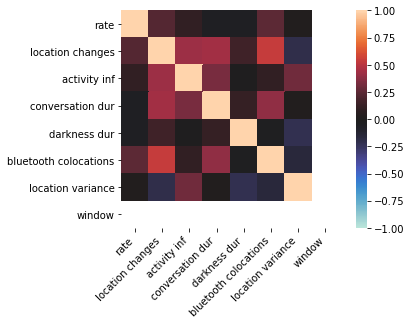

In [293]:
find_all_feature_importance([5], 'sleep', 'rate')